<h3>Introduction</h3>

We've complete our exploratory data analysis phase and now it is time to focus on the predictive modelling. We note that from our correlation matrix in our exploratory data analysis, we did not yield highly correlated features. Thus we do not have to worry about redundant features. If we did have a lot of highly correlated features, we would have to perform a feature reduction technique such as Principal Component Analysis. With this out of the way, let us start cleaning our data for predictive modelling.

<h3>Data Cleaning</h3>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import plotly.graph_objs as go
import plotly.offline as py
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [2]:
data = pd.read_csv('./Data/data.csv')

In [3]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
data["Attrition_numerical"] = data["Attrition"].apply(lambda x: target_map[x])

<h4>Feature Engineering & Categorical Encoding</h4>
As we have imported the libraries and data into our notebook, we will need to start feature engineering and encode our categorical data to be numerical for the predictve modelling algorithms to read the data.

In order to split our data from numerical columns to categorical columns, we will split it using the dtype method per the below.

In [4]:
# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
data = data.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in data.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = data.columns.difference(categorical)

Having identified which of our features contain categorical data, we will split this data into only categorical variables. Afterwards, we will perform the pandas function "get_dummies" to create dummy variales

In [5]:
# Store the categorical data in a dataframe called attrition_cat
data_cat = data[categorical]
data_cat = data.drop(['Attrition'], axis=1) # Dropping the target column

In [6]:
data_cat = pd.get_dummies(data_cat)
data_cat.head(3)

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1102,1,2,1,1,2,94,3,2,...,0,0,1,0,0,0,1,1,0,1
1,49,279,8,1,1,2,3,61,2,2,...,0,1,0,0,0,1,0,1,1,0
2,37,1373,2,2,1,4,4,92,2,1,...,0,0,0,0,0,0,1,1,0,1


In [7]:
# Store the numerical features to a dataframe attrition_num
data_num = data[numerical]

In [8]:
# Concat the two dataframes together columnwise
data_final = pd.concat([data_num, data_cat], axis=1)

Here we are creating our target column by mapping employees who have left and employees that have stayed.

In [9]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = data["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

In [10]:
attrition = [go.Bar(
            x=data["Attrition"].value_counts().index.values,
            y= data["Attrition"].value_counts().values
    )]

py.iplot(attrition, filename='basic-bar')

We can see from the above graph that we have a bit of skewness in our data. Most of our data leans towards employees staying rather than being evenly split. We will be using an oversampling technique known as SMOTE to treat this skewness.

In [11]:
# Import the train_test_split method
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Split data into train and test sets as well as for validation and testing
X_train, X_test, y_train, y_test = train_test_split(data_final, 
                                                         target, 
                                                         train_size= 0.80,
                                                         random_state=0);
#train, test, target_train, target_val = StratifiedShuffleSplit(attrition_final, target, random_state=0);

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



SMOTE to oversample due to the skewness in target

Since we have already noted the severe imbalance in the values within the target variable, let us implement the SMOTE method in the dealing with this skewed value via the imblearn Python package.

SMOTE(synthetic minority over-sampling technique) is a common technique used for oversampling when we have an imbalanced dataset. SMOTE works per the below:

1. We scatter all our positive cases (in this case, our positive cases are employees leaving).
2. We then choose a k number that would present the number of neighboring positive cases we would look at (we will take the default example in this case, we can tinker with this later on).
3.If you want to oversample the positive class by i=3 times, then for each positive case we do the following:

    We look at the k=10 nearest positive cases.
    We randomly choose i=3 of them.
    For each one of the 3 neighboring positive cases we have randomly chosen we add a ‘synthetic’ case somewhere between that neighboring positive case and the original positive case. In this last sentence between means within the exact straight line that passes through the 2 cases, and somewhere means the synthetic positive case is randomly placed in between.

In [12]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=0)
X_train_smote, y_train_smote = oversampler.fit_sample(X_train,y_train)

The below functions are used to evaluate some key metrics on our predictive modelling.

1. Confusion Matrix:  This is a 2X2 matrix that helps us visualize the the performance of our algorithm. It will show the amount of true positive (model predicted positive accurately), true negative (model predicted negative accurately), false positive (model inaccurately predicted data to be positive) and false negative (model in accurately predicted data to be negative).

2. Accuracy Score: Accuracy Score is the amount of true positive and true negative divided by the totals. This measures how accurately we were in predicting an employee leaving as well as employee staying.

3. ROC curve: This is the receiver operating Characteristic Curve. This is a graphical plot that measures the true positive rate on the Y axis vs the false positive rate on the X axis. A line going through the middle that is represented as Y = X is equivalent to predicting out positively 50% of the time. Thus we would hopefully expect a concave curve against the Y=X line to the left for our model to predict out true positive rate accurately.

4. AUC score: This is the area under the ROC curve for the our model. This related to the ROC curve and is measured as the area between our ROC curve and the Y=X. This will range between 0 to 1 with a score of 0 meaning that we have an equivalent model as flipping a coin (50% chance of getting a correct score) and 100% meaning that our model predicted accurately 100% of the time (this will mean we have done something wrong with our data and have overfitted or are using some future variable to predict our outcome).

5. F1 score: Measured as 2 X (Precision X Recall) / (Precision + Recall). Where precision = true positives / total positives and recall = true positives / (true positive + false negative). 

There are great metrics and each have their own significance. In our model, we will be focusing on the AUC score as we want to ensure that our model is predicting out employees that leave (which is our 'positive' in this case) at a good rate - i.e. above 50%.

In [13]:
# Import model evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve

# Define model evaluation method
def model_test(model, ytest, y_predict):
    print('The accuracy of {} model is: {:.2f}'.format(model, accuracy_score(ytest, y_predict)))
    print('The confusion matrix is:\n{}'.format(confusion_matrix(ytest, y_predict)))
    print('The auc score is: {:.2f}'.format(roc_auc_score(ytest, y_predict)))
    print('The F1-score is: {:.2f}'.format(f1_score(ytest, y_predict)))

# Define auc plotting method
def plot_roc(model, ytest, y_predict, y_predict_prob):
    fpr, tpr, _ = roc_curve(ytest, y_predict_prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr, label = 'AUC score by {}: {:.2f}'.format(model, roc_auc_score(ytest, y_predict)))
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'best')
    plt.xlim(0,1)
    plt.ylim(0,1)

<h3>Logistic Regression</h3>

We will start with the simplest classification predictive model. This model follows closely to linear regression 

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote)
log_reg_predict = log_reg.predict(X_test)
log_reg_predict_prob = log_reg.predict_proba(X_test)[:,1]

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [16]:
model_test('Logistic Regression', y_test, log_reg_predict)

The accuracy of Logistic Regression model is: 0.87
The confusion matrix is:
[[231  14]
 [ 25  24]]
The auc score is: 0.72
The F1-score is: 0.55


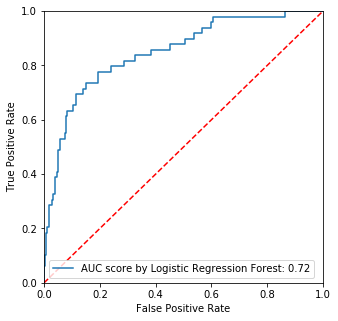

In [17]:
plot_roc('Logistic Regression ',y_test, log_reg_predict,log_reg_predict_prob)

We can see here that our model did fairly well without any hyperparameter tuning. We were able to accurately predict out 87% of the time and our positive percentage was 72% of the time. This is a good start but let us try some other classification algorithms and see if we can do better.

<h3>Random Forest Classifier</h3>

<p>Trying out a random forest classifier. This method is used with an ensemble of of decision trees. A decision tree as a standalone is known as a "weak learner" and is very susceptible to overfitting which will result in predictive performance being poor when it is fed new data. A random forest using multiple decision trees and does a 'voting' where it will look through multiple decision trees and will take a vote  and will take the maximum vote to ensure our data does not overfit.</p>

In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state=42)
rf.fit(X_train_smote, y_train_smote)
rf_predict = rf.predict(X_test)
rf_predict_prob = rf.predict_proba(X_test)[:,1]

In [20]:
model_test('Random Forest', y_test, rf_predict)

The accuracy of Random Forest model is: 0.87
The confusion matrix is:
[[239   6]
 [ 33  16]]
The auc score is: 0.65
The F1-score is: 0.45


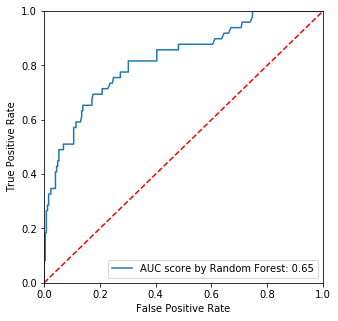

In [21]:
plot_roc('Random Forest',y_test, rf_predict,rf_predict_prob)

We can see per the above that our model predicted similar to our linear regression model. A neat feature of our random forest classifier is that we can analyze the importance of the feature and see what were strong data points used in determining whether an employee would leave or not.

A visualization is seen in the below graph.

In [22]:
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [23]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = data_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = data_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

We can see here that a highly important feature was employees who were not paid OT. The next highest features were monthly income and stock options. These can be used to explain to our stake holders what we need to investigate further.

<h3> Gradient Boosting Classifier </h3>

Gradient boosting is similar to random forest classifier. However, the key difference is that gradient boosting uses decision trees one at a time and each new tree helps correct errors made by the previously trained tree. Random forest will train each tree independently/simultaneously and will make be less proned to overfitting. None the less, this is another algorithm to test out.

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)
gb_predict = gb.predict(X_test)
gb_predict_prob = gb.predict_proba(X_test)[:,1]

In [27]:
model_test('Gradient Boosting', y_test, gb_predict)

The accuracy of Gradient Boosting model is: 0.86
The confusion matrix is:
[[236   9]
 [ 32  17]]
The auc score is: 0.66
The F1-score is: 0.45


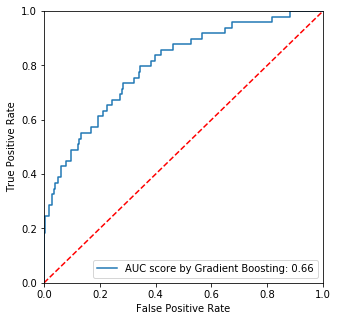

In [28]:
plot_roc('Gradient Boosting', y_test, gb_predict, gb_predict_prob)

We can see here that our model performed slightly weaker than our random forest classifier. Thus we will be taking the random forest classifier and tune the parameters and see if we can get a better model.

<h3>Tuning our model</h3>

We have chosen our random forest classifier as our model to go with for hyperparameter tuning. A key note is that the model will learn what parameters are best for prediction, however, hyperparameters (in this case, an example would be the amount of decision trees, how deep the trees should go, etc.) are seleted by data scientists in advance.  There are several wasy of hyperparameter tuning:

1. Manual - this is based on intuition/experience/guessing. We would iterate through this process until we run out of patience or are happy with our results.
2. Grid Search - we set up a grid of hyperparameter values and work through each combination, train the model and score on the validation data. We would test every single combination of hyper parameters which would be very inefficient.
3. Random search - set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.
4. Automated Hyperparameter Tuning - use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.

Typically we would start with a wide array of random search per method 3. For example, we would see if a max depth of 5 layers is enough in our random forest or if we would need a max depth of 20. Afterwards, we would use the grid search method to narrow it down - example being if the random search came up with a max depth of 20, we could test if we would need 18, 19, 20, 21, 22 as the max depth.

As we do not have time for grid search (and it is very similar to random gridsearch), we will only be implementing the random search.

In [30]:
rf_randomsearch = RandomForestClassifier()

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# parameters for GridSearchCV
# specify parameters and distributions to sample from
param_dist = {"n_estimators": [100, 1000, 2000, 3000],
            "max_depth": [3, 5, 10, 20],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]
             }
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf_randomsearch, param_distributions=param_dist,
                                   n_iter=n_iter_search)

In [33]:
random_search.fit(X_train_smote, y_train_smote)
random_search_predict = random_search.predict(X_test)
random_search_predict_prob = random_search.predict_proba(X_test)[:,1]

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



In [34]:
model_test('Tuned Random Forest Classifier', y_test, random_search_predict)

The accuracy of Tuned Random Forest Classifier model is: 0.87
The confusion matrix is:
[[237   8]
 [ 30  19]]
The auc score is: 0.68
The F1-score is: 0.50


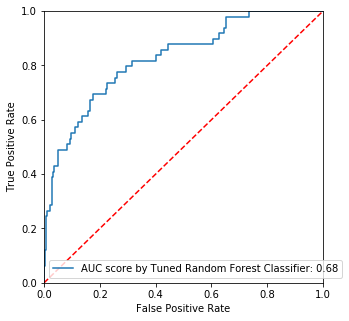

In [35]:
plot_roc('Tuned Random Forest Classifier', y_test, random_search_predict, random_search_predict_prob)

We can see from our hypertuned parameter, we were able to perform slightly better with an AUC of 68% with roughly the same accuracy overall.

<h3>Conclusion</h3>

We have conducted a pipeline for predicting emplopyee attrition. We were able to train aour model and returned 86% accuracy. We can use our model now on a monthly or bi-annual basis to see which employees are at risk of leaving and use our model to dig into whether they are overtime eligible and who are top performers to try and persuade them to stay within the company.

Although we were able to predict this out, we can perform more feature engineering to get more out of our data. We can also talk more with stakeholders to interpret our results and gather more data and more intuition on how we can use findings.